In [1]:
import pandas as pd # for working with dataframes
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from pathlib import Path # for retrieving files from directory
import networkx as nx # for making graphs
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib.image as mpimg # for images

In [2]:
data_dir = "./leaves/" # set data directory
file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
file_names.remove('.DS_Store') # remove .DS_Store file
file_names.sort() # sort the list of file names
file_names # check list of file names

page_numbers = [] # get the page of the illustration
for i in range(len(file_names)):
    page_numbers.append(file_names[i][:file_names[i].index("_")])

plant_numbers = [] # get the individual plant
for i in range(len(file_names)):
    plant_numbers.append(file_names[i][file_names[i].index("_")+1:file_names[i].rfind("_")])

page_plant_IDs = [] # get page_plant_IDs
for i in range(len(file_names)):
    page_plant_IDs.append(file_names[i][:file_names[i].rfind("_")])

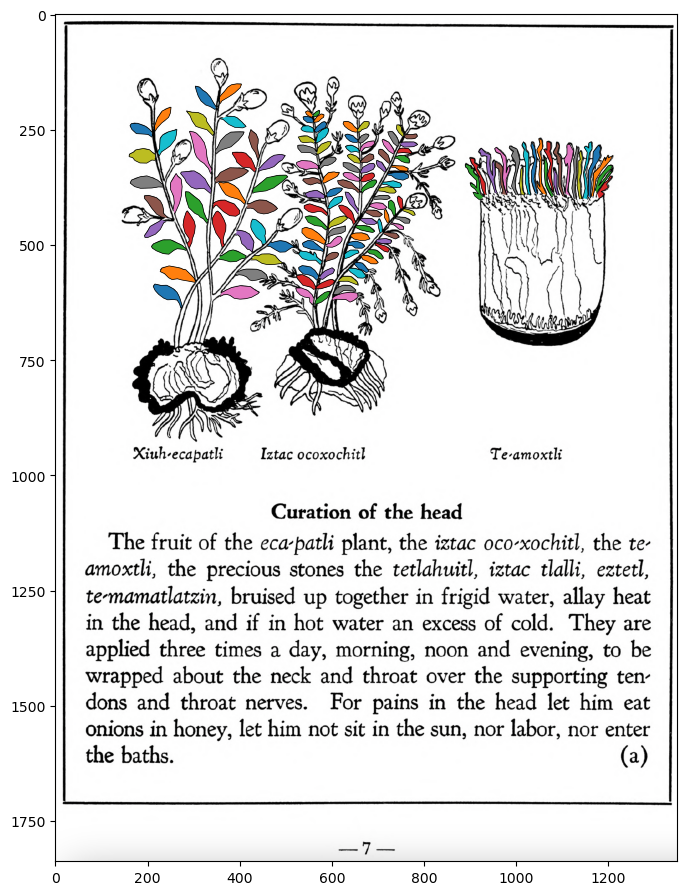

In [53]:
lo = "k" # leaf outline color
w = 0.5 # outline width
alfa = 1 # alpha

pic_dir = "./pics/" # set the directory of the pictures

curr_image = pic_dir + "p007" + ".png" # get the current image to plot on

plt.figure(figsize=(8.5,11)) # set figure size

img = mpimg.imread(curr_image) # read in current image
plt.imshow(img)

for i in range(len(file_names)): # plot each leaf
    lf = np.loadtxt(data_dir + file_names[i])
    plt.plot(lf[:,0], lf[:,1], c="k", lw=w)
    plt.fill(lf[:,0], lf[:,1], alpha=alfa)
